In [ ]:
import torch
import torchvision

from dataloaders import get_sars_dataloaders

import jax
import matplotlib.pyplot as plt
from trainer import TrainerModule
from model import InceptionNet
from flax import linen as nn

%load_ext autoreload
%autoreload 2

ImportError: attempted relative import with no known parent package

In [ ]:
train_loader, test_loader = get_sars_dataloaders()

In [ ]:
train_iter = iter(train_loader)
images, rewards = next(train_iter)

images.shape

In [ ]:
states = images[..., :3]
actions = images[..., 3:6]
states_hat = images[..., 6:9]

In [ ]:
def plot_trajectory(s, a, s_hat, num_steps=9):
    plt.figure(figsize=(20, 6))
    
    for i in range(num_steps):
        # State
        plt.subplot(3, num_steps, i+1)
        plt.imshow((s[i].numpy() * 0.5 + 0.5))  # Денормализация
        plt.title(f"State {i}")
        plt.axis('off')
        
        # Action (визуализируем как разницу)
        plt.subplot(3, num_steps, num_steps+i+1)
        plt.imshow((a[i].numpy() * 0.5 + 0.5))
        plt.title(f"Action {i}")
        plt.axis('off')
        
        # Next State
        plt.subplot(3, num_steps, 2*num_steps+i+1)
        plt.imshow((s_hat[i].numpy() * 0.5 + 0.5))
        plt.title(f"Next State {i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Визуализируем первую траекторию в батче
plot_trajectory(states, actions, states_hat)

In [2]:
train_loader, val_loader, test_loader = get_datasets()

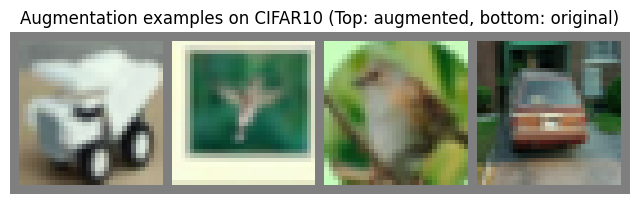

In [3]:
train_iter = iter(train_loader)
images, _ = next(train_iter)

NUM_IMAGES = 4

imgs = torch.from_numpy(images[:NUM_IMAGES]).permute(0, 3, 1, 2) # BCHW
img_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0) #HWB

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10 (Top: augmented, bottom: original)")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [3]:
def train_classifier(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs, start_from=start_from)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [4]:
googlenet_trainer, googlenet_results = train_classifier(model_class=InceptionNet,
                                                        model_name="InceptionNet",
                                                        model_hparams={"num_classes": 10,
                                                                       "activation": nn.relu},
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 1e-3,
                                                                           "weight_decay": 1e-4},
                                                        exmp_imgs=jax.device_put(next(iter(train_loader))[0]),
                                                        num_epochs=200)

  0%|          | 1/200 [01:31<5:04:32, 91.82s/it]


KeyboardInterrupt: 